# GPT-2 Fine-Tuning Tutorial using raw text corpus

From Rey Farhan (https://reyfarhan.com/posts/easy-gpt2-finetuning-huggingface/)




This is a simplified script for fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch on raw data. 

---------
Your task is to modify this assignment on raw text of your choice (I have put Pride and Prejudice as an example below) and include 10 sample generations from your chosen text that you find interesting. 


# Setup

In [1]:
!pip install transformers

     |████████████████████████████████| 2.2MB 17.5MB/s 
     |████████████████████████████████| 3.3MB 53.4MB/s 
     |████████████████████████████████| 870kB 52.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=94d6158c1d776cf3a0067ae7f49a2dac3aeb044b0c521dca8d697d7ad8f71deb
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [2]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
% matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
!nvidia-smi

Sun Apr 11 07:12:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Create Training Set

The data used to finetune the language model is a set of around 1000 DJ biographies, with the aim of generating them in the same general format and style.

This data isn't public so if you want to use this script, you'll have to source your own training set.

In [8]:
# mount my Google Drive directory and access the training data located there
gdrive_dir = '/content/gdrive/'
data_dir = os.path.join(gdrive_dir, "'MyDrive/Colab Notebooks'")
filename = 'prideAndPrejudice.txt'
drive.mount(gdrive_dir, force_remount=True)

Mounted at /content/gdrive/


In [9]:
# copy the data to the current Colab working directory
!cp $data_dir/$filename .

In [10]:
f=open(filename)
bios=f.readlines()
bios=[b.strip() for b in bios]
bios

['It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife.',
 'However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters.',
 '"My dear Mr. Bennet," said his lady to him one day, "have you heard that Netherfield Park is let at last?"',
 'Mr. Bennet replied that he had not.',
 '"But it is," returned she; "for Mrs. Long has just been here, and she told me all about it."',
 'Mr. Bennet made no answer.',
 '"Do you not want to know who has taken it?" cried his wife impatiently.',
 '"_You_ want to tell me, and I have no objection to hearing it."',
 'This was invitation enough.',
 '"Why, my dear, you must know, Mrs. Long says that Netherfield is taken by a young man of large fortune from the north of England; that he came down on Monday i

We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


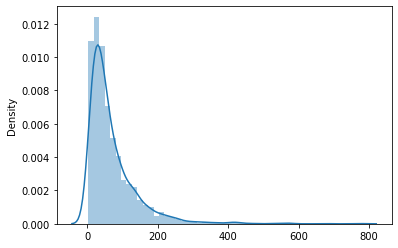

In [11]:
doc_lengths = []

for bio in bios:

    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [12]:
# the max token length   
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.0004847309743092584

In [13]:
np.average(doc_lengths)

69.48715462918081

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most bios will be fit under the 768 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens. 

In [14]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium


Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [15]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [16]:
batch_size = 2

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [17]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each bio in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens. 

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [18]:
dataset = GPT2Dataset(bios, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,856 training samples
  207 validation samples


In [19]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [20]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [21]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [22]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [23]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [24]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [25]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    928. Loss: 0.3894178569316864.   Elapsed: 0:00:51.
0:  bipartisan" But but how much he can he say.--No, but I believe that she is too great as a fool to think. She can no longer make him a man whom you must think a great friend to love. The very idea of marrying you began to make it all too easily to be imagined. That it were really so much more pleasing to you, than to yourself, and to myself, though it was impossible for them. I know how much better you would be if you could stay so much longer, and do much for others. I shall never think much of doing what he might not have done so far; but--you may make much more good at that, and shall be much better at it. But there is the whole world, when you consider your brother's whole life--his mother, his aunt, his friends--all this is without question--and you are no longer much inclined to speak of the whole situation."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    928. Loss: 0.16121838986873627.   Elapsed: 0:01:46.
0:  increasing"They have never been. They have not been in Scotland for the last two years; nor have they ever been at Netherfield; nor have they ever been at London. They have never been to Derbyshire. Their journey is not till winter or winter; and they do not come back to Scotland. Their house is at Netherfield, but it is not quite the house of Netherfield."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    928. Loss: 0.3062319755554199.   Elapsed: 0:02:40.
0: day"Yes; Lydia's sister was an object of many kindness. Her sister and I have talked. I am not. So well settled, indeed, of my understanding."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    928. Loss: 0.134327694773674.   Elapsed: 0:03:33.
0:  HangWhen Elizabeth was gone she went downstairs and bought a dress, as had been done before, and, after watching, she had the greatest pleasure in visiting such a beauty as Mr. Darcy. Her eyes were opened at Longbourn. She had the same pleasure in going down to the country, and walking about. When a man's age was approaching it would make even a moment of walking, and in the course of the journey she saw a few young ladies of whom she knew nothing. The young girls whom Elizabeth saw, were always of her own sex. The young woman who Miss Lucas saw had a great deal of politeness, and would allow her daughter to know when they had left Longb.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    928. Loss: 0.20536209642887115.   Elapsed: 0:04:27.
0:  foodsThe ladies were eagerly looking forward to hearing her address. She talked them all about it with a certain rapt attention; but Elizabeth did not seem to know how she felt.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    928. Loss: 0.08150218427181244.   Elapsed: 0:05:20.
0:  trail"My dear Darcy, do you know which day is she?"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of    928. Loss: 0.6885817646980286.   Elapsed: 0:06:13.
0: intendThey had a little time to spend: they only wanted Mr. Darcy. Kitty was not likely to come at all. When he entered the house, however, he looked as if he might still have time. To all the officers and girls there, he was no longer a man to be talked to; he was merely going to come soon, and everybody was to have dinner.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of    928. Loss: 0.2642064690589905.   Elapsed: 0:07:07.
0:  surroundYou soon discovered her. He did not look at her as she spoke, but as he walked towards her: the former looked angry with them, looked angry with them all. Miss Bingley, on her second visit, tried to persuade her of their attachment. Her sister's behaviour was nothing without resentment. Their marriage was at a loss to say. It did not seem quite right. Their behaviour against each other was never to be allowed to enter the present. They knew that if Mrs. Darcy did not return to the house without a very little more, and it was a very unimportant and useless marriage, it would be made known to them, in their hopes of succeeding with Miss Bennet. The resentment of the family would no longer continue in her head to be an excuse, for her sister had just done the same--an occasion for a much more favourable opinion of herself.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of    928. Loss: 0.07428628206253052.   Elapsed: 0:08:02.
0:  reflex"Yes, Mrs. Bennet. I have been deceived, as I am ashamed of you."

  Average training loss: 0.55
  Training epoch took: 0:08:16

Running Validation...
  Validation Loss: 0.32
  Validation took: 0:00:17

======== Epoch 2 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    928. Loss: 0.1263657510280609.   Elapsed: 0:00:53.
0:  display"And how could a girl so handsome as Mrs. Phillips have been so handsome?" said Darcy; "I cannot imagine how such a circumstance would have prevented their marrying--if not by the necessity of being handsome enough, or the necessity of marrying them with the smallest fortune. For the two eldest, it must be more than likely that either, or both, had the strength of appearance, or the inclination of fashion. They might have had great fortune, but there was only one of them."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    928. Loss: 0.21422205865383148.   Elapsed: 0:01:47.
0:  pastor"You are certainly a better young person than they themselves!"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    928. Loss: 0.29649391770362854.   Elapsed: 0:02:40.
0:  illicitAs the party entered the carriage, Jane had the greatest wish of seeing Mrs. Collins at Longbourn, where she could receive tea, as soon as her sister and her husband-in-law came down to town. But Elizabeth's plan of living in her own neighbourhood proved highly insufficient. For, as she frequently assured her husband, the prospect of their leaving home would be too much for her. It was at such a distance, and so distance so far away, that she really must not consider herself in danger of being mistaken for the person to whom she addressed her in this declaration.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    928. Loss: 0.0537886843085289.   Elapsed: 0:03:34.
0:  LiberationThe prospect of Mr. Darcy's being killed in such a way was dreadful, and I was obliged to take no orders from any of his correspondents, unless it was my own. When he informed them of his father's returning them all, I told him that I could not expect Mr. Darcy to be prevailed on to marry again again. Though they had been at Netherfield many months, it was impossible to escape their astonishment and surprise; on one side, there was all astonishment and horror at the sight of a young man with five thousand a year, standing there with a twelvemonth's income in the neighbourhood, with a respectable living there, and with nothing but ten thousand a year, a respectable estate, and a good family. On the other side, there was another, and very different kind of hope, which had been most cherished by his friend, who could not but remember seeing in his sister, that, however ill she had been on the point of qu

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    928. Loss: 0.14788015186786652.   Elapsed: 0:04:29.
0:  Nam"Oh! I have the good opinion of Mr. Wickham's, and I dare say my sister's, that is to be my profession."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    928. Loss: 0.4635508060455322.   Elapsed: 0:05:22.
0: ION"Well, I hope," cried Elizabeth, after a pause, "I think you must confess what I am. I feel that every thing that I believe in is false. It was a false statement. Who did you say was wrong, that I was wrong? But I am persuaded that whatever you may have suffered I have been ignorant of what you were under, and in fact I am convinced that this is because I was misunderstood."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of    928. Loss: 0.21540583670139313.   Elapsed: 0:06:16.
0:  glimpse"It is true. I remember it not, you see, as you always tell us, but, perhaps, I suppose it to be merely a case of common sense. I did not, I did not pretend to give you any explanation."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of    928. Loss: 0.2444801926612854.   Elapsed: 0:07:09.
0:  Laure"Yes, or I suppose it. If my father does not like it, I will not think to pass it up. But I know _that_ I would not go so far. I will go to my aunt's, as soon as I get acquainted with her."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of    928. Loss: 0.2547406554222107.   Elapsed: 0:08:02.
0: ism"Yes, I have done; but I _must_ take it for my own."

  Average training loss: 0.30
  Training epoch took: 0:08:17

Running Validation...
  Validation Loss: 0.31
  Validation took: 0:00:17

======== Epoch 3 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    928. Loss: 0.23440882563591003.   Elapsed: 0:00:52.
0: oun"This young lady, Mr. Darcy, who could have lived with others but toil away in the farm, has been brought up with us."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    928. Loss: 0.28719672560691833.   Elapsed: 0:01:45.
0:  election"Yes, indeed, that is true," said Elizabeth, "and I am very glad we parted with Mr. Bingley, as it shows a mutual affection for one other, for the sake of both, his happiness is absolutely dependent on the kindness and goodness of another. And though there may be faults in our conduct, he has the means of making all the difference."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    928. Loss: 0.07045816630125046.   Elapsed: 0:02:38.
0:  crazy"Certainly," replied Mr. Gardiner, "it would not be advisable to _remind_ of such a point."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    928. Loss: 0.8061708211898804.   Elapsed: 0:03:30.
0:  bench"My mother died about eight months ago. She was married. It seems quite shocking to me. My eldest child, Miss Lucas Lucas, was so ill a month. At that moment I told her story. But she did not listen. Perhaps my father did not, too. Mr. Collins told her of a connection between us. When it was discovered he asked her why she had not settled her own affairs. She answered with: 'You did not know that you had two daughters married before. You were not very rich. How can you be in so small a family? You are likely to think that some day will bring some relief to my family that may not be in your favour. My father, you know, was the godson of my father in town about a long time, and you know that they were married, and _they_ were settled. I did not write to you. He wrote it as his own, and his character told it. He came home only the


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    928. Loss: 0.13294483721256256.   Elapsed: 0:04:25.
0:  incorporated"Oh, dear! I know it!" said Miss Darcy, still smiling at her father. "Perhaps not as much as that, but I believe he can do something for him. Oh, _that_. I wish he had been so much better, but we cannot know what. He is not good enough to be trusted. And now we may as well forget your feelings, you may well believe me. There have been many a schemes of us all. We never intended to expose Mr. Darcy. I suppose there will be a few more. However, we will not expose ourselves, you know."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    928. Loss: 0.15174004435539246.   Elapsed: 0:05:19.
0: Peter"Oh! no--it will be my mother's--and Wickham's. But to see my sister-in-law and Mr. Darcy together, I hope they will be good friends again; and I hope to hear more of both of them in the same parish. Mrs. Phillips herself says she has a great deal to relate; but it does not appear to be in the least. Only think of Mr. Darcy's seeing me.--Yours"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of    928. Loss: 0.4033648371696472.   Elapsed: 0:06:12.
0: uring"How far, Madam, I might call it possible," said she, "for a man to be always moving about about the room and talking in terms of dancing, and then getting wet."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of    928. Loss: 0.07864251732826233.   Elapsed: 0:07:05.
0:  reproductive"And how often have you ever seen your partner dance?"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of    928. Loss: 0.39940953254699707.   Elapsed: 0:07:57.
0:  zoneAs soon as Mr. Darcy returned to Jane, the whole party, rejoicing in her good wishes, and in general astonishment at her ungracious treatment, set off together in the attempt to console her of the truth; and at that hour, a short conversation was just to be had between them.

  Average training loss: 0.26
  Training epoch took: 0:08:12

Running Validation...
  Validation Loss: 0.32
  Validation took: 0:00:17

======== Epoch 4 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    928. Loss: 0.4784427285194397.   Elapsed: 0:00:52.
0:  commits"Good gracious! What are you talking of?" cried Maria, endeavouring to lift up her eyes.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    928. Loss: 0.10675109177827835.   Elapsed: 0:01:45.
0:  irony"I knew of you at a ball this evening."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    928. Loss: 0.34432387351989746.   Elapsed: 0:02:37.
0:  Sah"They have often been my intimate friends with Wickham," she added, "as I saw him before; and since he left the country, I have known him better; and I cannot vouch for it myself, since I am persuaded, from the whole of that period, that his attachment to me was as natural as it was. I believe not it will be forgot, therefore, that Wickham will always be with them, after we have both been together for a very long time."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    928. Loss: 0.3349863588809967.   Elapsed: 0:03:30.
0:  Bryan"I was only ashamed of myself, for, though I should never have been esteemed by others, I should have always had hopes of happiness. I had the happiest memories of my life, and certainly the happiest memories of the whole. My father had made me a sincere apology for having injured my relations, by which I could only add, 'Oh! my dear father, I am so grieved for that ill-judged remark, that I must have told you before. And now, do you think there was some cruelity in the case, as you so often tell me, against your young cousin's character, in which you were accused of cruelty to yourself and to your own family? Heaven forbid! My father should not have allowed himself to be guilty of that. My mother should have resigned."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    928. Loss: 0.034921448677778244.   Elapsed: 0:04:24.
0:  spirits"My dear madam, do not repeat the actions which I have done. If you were to see them, you would find them unpardonable."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    928. Loss: 0.8329513669013977.   Elapsed: 0:05:16.
0:  sees"It will be very agreeable to _her_ to judge _me_."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of    928. Loss: 0.22696024179458618.   Elapsed: 0:06:09.
0:  hungryIn a few minutes, Mrs. Bennet began the projected conversation. Miss Bennet spoke in such terms of finery and ceremonious secrecy as made the possibility of Bingley's having any share of society exceedingly probable, that it should be everywhere believed, that all his acquaintances must be kept a secret, to assure his father of the probability of Miss Darcy's being in love with her, and that Jane would certainly not quit Netherfield. Mrs. Bennet thought that the subject was endless, and when Bingley was removed to the Parsonage, as had been conjectured, she saw all manner of encouragement in its flight, and all manner of encouragement for him to marry Miss Darcy and make the offer. Mr. Darcy, she believed, would not consent to a meeting with her on this score; and on this signal of cordiality, he kissed the lips of all the ladies at Parsonage; and when Miss Bennet was revived, the conversation was turned

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of    928. Loss: 0.2921043634414673.   Elapsed: 0:07:03.
0:  PT"If we had an estate in common," he cried, "I should be sorry to think of setting it against a man that has so little money to live on, if I should have it. But, however, that estate does not comprise a vast fortune, and if we did not own it, I should have no opinion of it."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of    928. Loss: 0.1925615668296814.   Elapsed: 0:07:56.
0: ü"How much I will take on Mr. Bingley is beyond me, I can easily believe."

  Average training loss: 0.21
  Training epoch took: 0:08:11

Running Validation...
  Validation Loss: 0.34
  Validation took: 0:00:18

======== Epoch 5 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    928. Loss: 0.12268596887588501.   Elapsed: 0:00:52.
0: ruce"You would not have put yourself so much at a disadvantage as I am by this discovery, I believe, had I not discovered it myself earlier."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    928. Loss: 0.05989032983779907.   Elapsed: 0:01:45.
0:  derivatives"I had once or twice once told Miss Bennet my resolution of thanking you for the kind attentions you had received me during my visit. I feel all the good sense and good intention of speaking to you. We parted on good terms, and afterwards parted with all the kind of civility you seemed so ready to give to me; you showed me, indeed, how much you liked me, and showed me all the particulars which were of so much interest to both of us."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    928. Loss: 0.11189917474985123.   Elapsed: 0:02:38.
0: "I will endeavour to do as much as I can; but this subject matters greatly with me, and I shall endeavour to make the most of every moment. You must allow me to confess what I think of your daughter, and what I hope to do myself in the course of it. I do not regard your condition in any other way than as arising on your side from the marriage of your nephew. Your dependence on me cannot bear the thought that, under such circumstances, the very condition which I have been so concerned in affording you, could, in your disposition, have renewed to give you relief from obligations which, at that time, you must altogether suspend, without your having been aware of the other obligations. You cannot, I am persuaded, endeavour to remedy your feelings by any means that may be eligible. Assistance is absolutely indispensably to me, but I am perfectly willing to assist you in every endeavour of which you have undertaken.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    928. Loss: 0.11340869218111038.   Elapsed: 0:03:32.
0:  remembering"Good Heaven!" cried her mother, "what am I to do? What sort of guardians do you send them? I never heard of you before, and since I have known her from my childhood I have not known how I should manage them. They are not very clever people, nor I dare say they are at all worth knowing. But they must be kept under frequent observation, and if they are good enough they may live to see many years. There is nothing to be done that I can think of without having a list of their good qualities; and though I have not the least intention of going on, I can easily perceive that a young man of sense and education, moreover with such an air and such manners, should not be properly guarded against."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    928. Loss: 0.06446993350982666.   Elapsed: 0:04:26.
0:  SourcesAfter a little alteration, or an apology for troubling her relations, Jane could not be prevailed on to follow their example again, and return to their friends. Miss Bennet was determined to show her friends again, and she wrote to Mr. Collins directly, with all her heart; and, in spite of his threats and remarks against her relations, she made him voluntarily yield to her, and walk away, leaving them both to their fate.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    928. Loss: 0.4323817491531372.   Elapsed: 0:05:19.
0: emsJane was not in such a way to avoid conversation with any of them as when Darcy had first called; and Elizabeth was so far from going away that it did not seem likely to be necessary for her to introduce any to whom she could not help saying:


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of    928. Loss: 0.3899417221546173.   Elapsed: 0:06:12.
0: tz"I have now given you the assurance, under these circumstances, of the sincerity, the delicacy, and the assurance of respect which I demand. I trust you will not esteem them unwillingly. No, no, depend upon my serving you. You must satisfy me in every possible method of passing this evening. I shall summon you by post, to show off your morning civility. My compliments to Mr. and Mrs. Gardiner, my dear Miss Eliza, and my fair niece Elizabeth, are all for the best. You will not regret it. I thank you again and again for your condescension to join me and my sister in dancing at the Parsonage this evening, and for your civility towards the young couple that we were yesterday invited to play at last. Miss Bennet has a large collection of fine muslins and cambric in her shop-boy-piece, Mr. Darcy. I dare say there are not half as many as are made


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of    928. Loss: 0.2589453160762787.   Elapsed: 0:07:06.
0: matic"Not so hasty, then. Mr. Bingley must marry. Promise me--I want it now."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of    928. Loss: 0.04449087008833885.   Elapsed: 0:07:58.
0:  synd"You are very strange, Mr. Bennet, to think of a man who lived in Hertfordshire!" cried his wife.

  Average training loss: 0.17
  Training epoch took: 0:08:13

Running Validation...
  Validation Loss: 0.38
  Validation took: 0:00:17

Training complete!
Total training took 0:42:37 (h:mm:ss)


Let's view the summary of the training process.

In [26]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.55,0.32,0:08:16,0:00:17
2,0.30,0.31,0:08:17,0:00:17
3,0.26,0.32,0:08:12,0:00:17
4,0.21,0.34,0:08:11,0:00:18
5,0.17,0.38,0:08:13,0:00:17


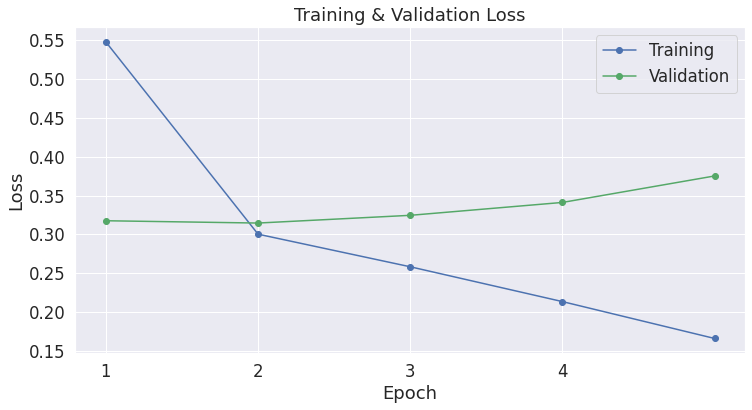

In [27]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [28]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [29]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [30]:
!ls -l --block-size=K ./model_save/

total 499796K
-rw-r--r-- 1 root root      1K Apr 11 08:09 added_tokens.json
-rw-r--r-- 1 root root      1K Apr 11 08:09 config.json
-rw-r--r-- 1 root root    446K Apr 11 08:09 merges.txt
-rw-r--r-- 1 root root 498452K Apr 11 08:09 pytorch_model.bin
-rw-r--r-- 1 root root      1K Apr 11 08:09 special_tokens_map.json
-rw-r--r-- 1 root root      1K Apr 11 08:09 tokenizer_config.json
-rw-r--r-- 1 root root    878K Apr 11 08:09 vocab.json


In [31]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 487M Apr 11 08:09 ./model_save/pytorch_model.bin


In [32]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ $data_dir

# # Load a trained model and vocabulary that you have fine-tuned
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

# Generate Text

In [33]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0: "We had better go the other way."


1: "Yes, of course of course."


2: He was now on the point of no returning till they reached the plantation, for that part of the evening, when he was first invited to breakfast by Mrs. Bennet. The invitation was accepted; and as he took leave of his relations, the whole party, with many of their aunties, were seated at table. The youngest, Kitty, was eight years old; the tallest, Lydia, eight years old; and, though the two youngest were very small, the younger ones were as handsome as Mr. Darcy's sisters. In distinguishing the younger girls from the rest, he was particularly instructive; for she was to prefer either Jane or Elizabeth to anybody else, for it was not in her power to determine between the two.




(10 pts) These aren't bad at all! Now train the model on your chosen text and report 10 example generations that you think are interesting!


In [54]:
filename = 'speeches.txt'
!cp $data_dir/$filename .

f=open(filename)
bios=f.readlines()
bios=[b.strip() for b in bios]
bios = [x for x in bios if x != '']
bios

['\ufeffSPEECH 1',
 "...Thank you so much.  That's so nice.  Isn't he a great guy.  He doesn't get a fair press; he doesn't get it.  It's just not fair.  And I have to tell you I'm here, and very strongly here, because I have great respect for Steve King and have great respect likewise for Citizens United, David and everybody, and tremendous resect for the Tea Party.  Also, also the people of Iowa.  They have something in common.  Hard-working people.  They want to work, they want to make the country great.  I love the people of Iowa.  So that's the way it is.  Very simple.",
 "With that said, our country is really headed in the wrong direction with a president who is doing an absolutely terrible job.  The world is collapsing around us, and many of the problems we've caused.  Our president is either grossly incompetent, a word that more and more people are using, and I think I was the first to use it, or he has a completely different agenda than you want to know about, which could be p

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


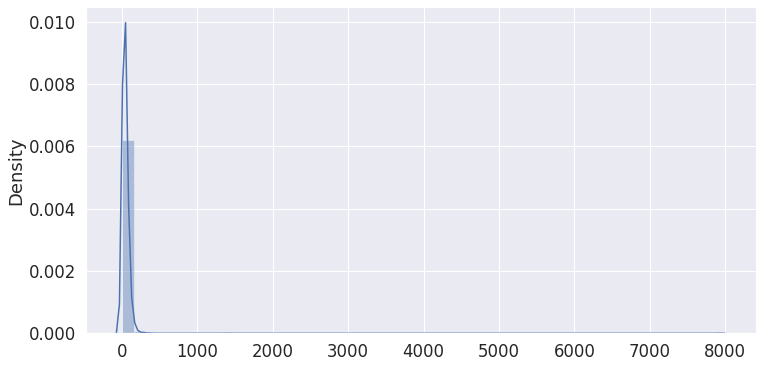

In [55]:
doc_lengths = []

for bio in bios:

    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [56]:
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.00046948356807511736

In [57]:
np.average(doc_lengths)

50.194835680751176

In [58]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


In [59]:
dataset = GPT2Dataset(bios, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

3,834 training samples
  426 validation samples


In [60]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [61]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,917. Loss: 0.17953041195869446.   Elapsed: 0:00:53.
0:  bipartisan to have the "red. that they have gone where it is the most going to have a "n-way you do the I need to go with the "most you want. do the world and going to do – – – –The – – – they —… TheThe –’ –the.And’are theSo’ — Theare theThe been are the — they. I knowthey were not gone. them.…



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,917. Loss: 0.25562191009521484.   Elapsed: 0:01:47.
0:  increasingS’t the United States. I’re going to be in the US to be in a country which is like America that is what we are doing here. And these things I’ve heard. So Ive got it, Ive got it. You look at it, you know it, you’re going to be like what’s happening in our country? Youre going to have to have to keep a country here. You have to’t make it a little bit of money off here in the world and don’t know it’t happen here? So do you’re going to have to get money off here.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,917. Loss: 0.30140310525894165.   Elapsed: 0:02:40.
0: dayOne. We’re not going to use their money for anything like the amount you can spend on your money.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,917. Loss: 0.4042942225933075.   Elapsed: 0:03:32.
0:  HangThe American worker is going to be taken advantage of China in trade, as we have so much of privilege in this world and so many countries.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,917. Loss: 0.14511217176914215.   Elapsed: 0:04:25.
0:  foodsBut I didn’t think it was so big. I didn’t think it was so big. I really didn’t think it was so big. And it’s so much.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,917. Loss: 0.18224404752254486.   Elapsed: 0:05:17.
0:  trailAnd you know, they get a lot of money, and you get a lot of money from you. And I’m talking to Hillary Clinton, and I’m talking to her. But I’m talking to her. I think she has more money than Trump because she’s not so good. I think you get a lot from me. And I think you get a lot from the people that get $.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,917. Loss: 0.27324536442756653.   Elapsed: 0:06:10.
0: intendI mean, for instance, it has been a long time that there have been millions of people trying to get these jobs, and many of these people are doing it for less money than you can imagine.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,917. Loss: 0.13460077345371246.   Elapsed: 0:07:02.
0:  surroundI think somebody’s probably self-funding them. Okay? So you know, my book has a little bit in the book where they say you don’t know how that is. Okay? Right?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,917. Loss: 0.10616878420114517.   Elapsed: 0:07:55.
0:  reflexThey will be very serious.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,917. Loss: 0.25674161314964294.   Elapsed: 0:08:47.
0:  displayBut I know if you say, $1.5 trillion dollars, $2 trillion, $2 trillion, we're going to make it out as a lot of money and get our people that will put back in their own place. And that’s a lot of jobs that’s going to be lost if they’re not elected. Now it’s going to be the other thing. He’ll probably’t will have been a president that’s going to make a very successful president if our people don’t want us to do it for any period of time, period of time, no longer going to come into office. If we’re going to have any more, no longer going to come in. Okay? We’re going to be able to take care of our prisoners, our prisoners we’re not going to have any longer.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,917. Loss: 0.1835140734910965.   Elapsed: 0:09:41.
0:  pastorWe’m going to make America great again. We’re going to make America great again. We don’t know where. We can’t know. We have a great border. The best way to do it is to keep the country of United the way. We’re going to make the country great again. We’re going to make America great again.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,917. Loss: 0.13354359567165375.   Elapsed: 0:10:34.
0:  illicitAnd I mean, we’re doing some great things.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  1,917. Loss: 0.20117796957492828.   Elapsed: 0:11:26.
0:  LiberationBut I love to be doing things. I love everything about the Mexican border. It’s not so easy. Just because I love the Mexican border and I love the border with Mexico and I love the wall with the wall, I love Mexico and I love the wall with the wall. That’s good for the border.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  1,917. Loss: 0.10855407267808914.   Elapsed: 0:12:18.
0:  NamOn a date of record and with $6 million in real cash, I’m telling you that it’s never even met the expectations that we need.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  1,917. Loss: 0.08358248323202133.   Elapsed: 0:13:11.
0: IONWe have to have a responsible foreign policy. So a responsible foreign policy. If you don’t believe me, the worst thing’s happening now is ISIS. If you don’t believe me, you can’t believe me. If you don’t believe me, you can’t believe what we do now. They’re doing with radicalized cells across the world and that’s what they’re doing right now. They are doing with a group of people that are bringing back Islamic radical Islam with drugs and they’re rapists. They’re rapists.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  1,917. Loss: 0.1096920594573021.   Elapsed: 0:14:04.
0:  glimpseIt doesn’t matter where you go from all to this because I mean, you know, everybody knows that. You have to understand the kind of stuff that happens with us.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  1,917. Loss: 0.10063577443361282.   Elapsed: 0:14:56.
0:  LaureSo we’re going to have great trade deals – we’re going to give a lot of bad deals that have some of the bad deals.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  1,917. Loss: 0.15760459005832672.   Elapsed: 0:15:48.
0: ismWhat’s a big number. What’s a big number. I’m a big number. I’m a big number and I think it’s got a long-term relationship and a lot of people will say a lot. But I’m a big number.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  1,917. Loss: 0.2069856971502304.   Elapsed: 0:16:41.
0: ounI don’t have time to waste trying to do something about it.

  Average training loss: 0.26
  Training epoch took: 0:16:50

Running Validation...
  Validation Loss: 0.20
  Validation took: 0:00:36

======== Epoch 2 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,917. Loss: 0.12531575560569763.   Elapsed: 0:00:52.
0:  electionWe’re going to use this stuff really hard. We’re going to use all of this stuff. We’re going to use this stuff really hard.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,917. Loss: 0.21006150543689728.   Elapsed: 0:01:44.
0:  crazyAnd we can do it. Right?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,917. Loss: 0.6587506532669067.   Elapsed: 0:02:36.
0:  benchThey just let us do it. I mean, look, they said, "We’re going to put our resources to help your people. We’re going to give you what’s going to be so important, just don’t go anywhere else. Okay? Don’t worry about it. Don’t worry about it. Don’t worry about it. Don’t worry about it. Don’t worry about it. I don’t care about your money. We are going to get it out of here."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,917. Loss: 0.09434966742992401.   Elapsed: 0:03:29.
0:  incorporatedBut everybody comes to the same thing.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,917. Loss: 0.18616771697998047.   Elapsed: 0:04:21.
0: PeterYou know, the other thing is the energy that I build.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,917. Loss: 0.09736371785402298.   Elapsed: 0:05:14.
0: uringThe burden is on Hillary Clinton to tell us why she believes that America First means the American people cannot enter into any dangerous zone that anyone believes to be a threat to them. It is one thing she believes she has not been able to straighten out, which we all know is a big problem.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,917. Loss: 0.12318176031112671.   Elapsed: 0:06:06.
0:  reproductiveI think that’s what’s happening with respect to China. We have so much debt, so much debt and so many problems, they can buy things for us with nothing.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,917. Loss: 0.3039207458496094.   Elapsed: 0:06:58.
0:  zoneAnd we’re going to get rid of Common Core. And you know it’s going to be so great, I see your people outside of Iowa. You look at a lot of the networks that are so powerful right now in Iowa.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,917. Loss: 0.24487712979316711.   Elapsed: 0:07:51.
0:  commitsSo we’re going to have all – I mean, it’s got to be very, very complicated.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,917. Loss: 0.10306809842586517.   Elapsed: 0:08:43.
0:  ironyBut we’re going to do a great job with the evangelicals. We’re going to do a fantastic job with the evangelicals. We’re going to have a great relationship with evangelicals.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,917. Loss: 0.17872951924800873.   Elapsed: 0:09:36.
0:  SahI know what is going to happen, it’s not going to happen. But when you think of it, it’s going to happen.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,917. Loss: 0.14355553686618805.   Elapsed: 0:10:28.
0:  BryanTRUMP:


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  1,917. Loss: 0.17416314780712128.   Elapsed: 0:11:20.
0:  spiritsLook at this.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  1,917. Loss: 0.04610416293144226.   Elapsed: 0:12:12.
0:  seesAnd I'm going to be doing great with people, with people who look good. We're going to work very closely together. We're going to do very closely what I'm doing. It's going to be very, very exciting.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  1,917. Loss: 0.08849121630191803.   Elapsed: 0:13:04.
0:  hungryWe will make our communities wealthy. The United States will be wealthy again. We will not be poor again. We will win again. We will not be poor again.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  1,917. Loss: 0.05139412730932236.   Elapsed: 0:13:56.
0:  PTAnd we’re going to go see – I’ll tell you I’m not looking at you because there’s a tremendous amount of false equivalency in these two words, and I’m a practical guy. I think it’s going to be an easy way of putting my side up. And I’m very good at it. But I’m going to have real issues. And honestly, I’m going to vote for Hillary. But you know what that means. I’m just saying. We have to change that. And I’m saying.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  1,917. Loss: 0.20765891671180725.   Elapsed: 0:14:50.
0: üWhen you think about it for a second, we’re very much over here right now. It’s so interesting. I don’t even want them to have to do it. You know, you know, it’s so interesting.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  1,917. Loss: 0.1351350098848343.   Elapsed: 0:15:42.
0: ruceNow, you know, when the other day they said, "Wait a minute." It’s like they’re getting out. We’re doing great. They’re doing great. They’re doing great in China.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  1,917. Loss: 0.4674343168735504.   Elapsed: 0:16:35.
0:  derivativesThe people who voted for Trump during the campaign said they were disappointed when he left. They were disappointed when he left.

  Average training loss: 0.17
  Training epoch took: 0:16:44

Running Validation...
  Validation Loss: 0.21
  Validation took: 0:00:36

======== Epoch 3 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,917. Loss: 0.1630983203649521.   Elapsed: 0:00:52.
0: And you know, I’ve been with Ivanka for a very long time. I’ve been with Ivanka a very long time. Ivanka and Eric and Ivanka and Ivanka, Eric and Ivanka, Ivanka and Ivanka.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,917. Loss: 0.09704679250717163.   Elapsed: 0:01:44.
0:  rememberingYou know, if you look at what it did to Israel, you have the right to self-inspect. You know, we have to control. We have to control.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,917. Loss: 0.1332128942012787.   Elapsed: 0:02:37.
0:  SourcesThank you, everybody. Thank you, everybody. Let us go over one last thing – let’s go over three, four, five, six. And we’re going to take it all over.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,917. Loss: 0.06517904996871948.   Elapsed: 0:03:29.
0: emsWe will not lose our jobs. Our jobs will be back. We’re going to save our wealth. Our country is going to be great.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,917. Loss: 0.09277714788913727.   Elapsed: 0:04:22.
0: tzWe’re going to have a country that has the power over everybody.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,917. Loss: 0.07377324253320694.   Elapsed: 0:05:14.
0: maticWith Japan and Mexico and all these places we have a trade imbalance. We pay a lot of money for our apartments in apartments. We buy apartments from China, for apartments.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,917. Loss: 0.2575938105583191.   Elapsed: 0:06:06.
0:  syndYou know, I want to thank my daughter. And Melania just said to me she’s very special. He’s not going to say about that. They don’t want to show up for that reason. So we’re going to be celebrating this election, and I want to be celebrating.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,917. Loss: 0.05279169976711273.   Elapsed: 0:06:59.
0:  gamI’ll never be embarrassed to lead the Republican Party to victory if we do. You have to lead it. Okay?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,917. Loss: 0.20365281403064728.   Elapsed: 0:07:51.
0:  injuryI’ll tell you I got to go to Dallas and I think we can win New York, because I’ve been watching the New York Times. They’re very dishonest people. They’re very dishonest people.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,917. Loss: 0.03980141878128052.   Elapsed: 0:08:43.
0: azaI am proud to be a part of the establishment. I know all of the great people. I know so many of them. I love the people. We have so many of the people. We have so many of the people. And we have tremendous support. We have tremendous numbers of people. We have unbelievable support.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,917. Loss: 0.2603034973144531.   Elapsed: 0:09:36.
0:  membraneWe had a meeting recently in L.A. We had a great gathering of people. And I had a good evening. I had a great gathering. But there were some very beautiful people – a group of people.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,917. Loss: 0.1012309119105339.   Elapsed: 0:10:28.
0: ijingAnd you know, we did it. We did it. And it’s not supposed to happen anymore. So it’s sort of interesting to me because they said, "Well, it’s a very negative situation" to this man and he has a good friend who likes him very much. He says he’d like us.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  1,917. Loss: 0.09403080493211746.   Elapsed: 0:11:21.
0:  castWe’re going to rebuild our military. That’s why NATO must take over our nuclear arsenal. That is why we need to get them to do their job properly. I said, why aren’t we paying?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  1,917. Loss: 0.4477303624153137.   Elapsed: 0:12:14.
0:  purchYou know, what happens when you see – you look at what happened to John McCain. I was in the Marine – I had four people. I’ll tell you that I had four people that I actually love. I’ll tell you what. I loved the Marine because they’re the best – they’re tough, smart, tough and tough, right?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  1,917. Loss: 0.12063158303499222.   Elapsed: 0:13:07.
0:  shouldersWe’re going to bring you back. We’re going to bring you back. We’re going to bring it back. We’re going to bring back jobs, our infrastructure, our roads and everything, so importantly.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  1,917. Loss: 0.2135007530450821.   Elapsed: 0:13:59.
0:  builtThis is a record of tremendous amounts of money. And we will be very happy. Thank you very much. Thank you very much. Thank you very much everybody. Thank you very much.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  1,917. Loss: 0.07300354540348053.   Elapsed: 0:14:51.
0:  openlyI’m not a man that was fighting for a paycheck but a job, and I was, you know, we’re going to bring back the jobs and we’re going to be terrific and our manufacturing will be phenomenal and if people want jobs that can be shipped across the border and they don’t have an incentive to work for another job.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  1,917. Loss: 0.19359539449214935.   Elapsed: 0:15:44.
0:  haltedIn fact, Hillary is the only candidate who’s running for President. And the reason I said that — I’m the only candidate who’s going to run for President. And the reason I’m running is a tremendous amount of money that I’m running for the presidency. That’s what I’m doing. We’re going to have a wall; Mexico is going to come through, and a lot of money that we need to build this wall is going to come through.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  1,917. Loss: 0.08573777973651886.   Elapsed: 0:16:37.
0:  NikAnd the number of – now, they’re leading by almost 300%. You’re looking at these numbers – they’re leading by way by a lot. So it’s not even close. And they’re leading by a lot because we have so much money in invested in education – tremendous – in education.

  Average training loss: 0.14
  Training epoch took: 0:16:47

Running Validation...
  Validation Loss: 0.20
  Validation took: 0:00:36

======== Epoch 4 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,917. Loss: 0.035939935594797134.   Elapsed: 0:00:52.
0:  tinAnd then I’m at 50 percent. And then I’m at 32 percent. So when I was at zero percent, and you know, you’re getting hit by so many different elements and you know, it’s just very, very sad to think that we’re at 33 percent, and that just goes way down.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,917. Loss: 0.24209269881248474.   Elapsed: 0:01:45.
0:  clinicalYou know, I really do. If you look at what happened with Ben, he lost his whole Super PAC. You know, you know what I mean. That’s very sad. That’s very sad.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,917. Loss: 0.1127476766705513.   Elapsed: 0:02:37.
0: lectionsAnd he [referring to Ted Cruz] has not been treated fairly. He’s not been a great businessman.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,917. Loss: 0.08544085174798965.   Elapsed: 0:03:29.
0: elsI won’t say it in any big league fashion. I won’t say it in any big league fashion. I don’t think I should tell anybody.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,917. Loss: 0.14641405642032623.   Elapsed: 0:04:22.
0: labI don’t even know if they’re going to do as well as they should. But I think they can do something that’s important and there are some people outside. I don’t know if they’re going to do.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,917. Loss: 0.040742427110672.   Elapsed: 0:05:14.
0:  tripleNo, no, they don’t want — they don’t like me or this, believe me, but we have a lot more people than our president. It is — they have more than anybody in the world.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,917. Loss: 0.04574256390333176.   Elapsed: 0:06:07.
0: 220But the point is, the oil is being sold. The oil is being sold. And every time we get close to $20 billion in the Middle East, we can see the sign. The sign is the wrong price because people are selling it. It’s true. And we’re getting that money. So, we are getting that money from Saudi Arabia. But they get it from the United States. The $ was on the Interpol. The $ was on the Obama administration."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,917. Loss: 0.1067822203040123.   Elapsed: 0:07:00.
0:  SeeAnd it’s going to be a very interesting evening.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,917. Loss: 0.2329442799091339.   Elapsed: 0:07:52.
0: @@A few days ago, I watched the television. The cameras swerve. They are moving from the ceiling. And then the cameras swoop over and I say "Okay, we’re going to do well." And then I say you’re going to win. And then it goes to the floor. And the cameras swoop over and we have a little break.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,917. Loss: 0.09240201115608215.   Elapsed: 0:08:45.
0:  hostThey said – look at all the credit I got for it. So I didn’t mention names.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,917. Loss: 0.13015511631965637.   Elapsed: 0:09:37.
0: roleAnd I can tell you that the establishment doesn’t want money to be spent – they want money to be spent in Washington. They’ve got trillions and trillions of dollars overseas. They’ve got trillions more dollars now than they used to be spending.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,917. Loss: 0.19428661465644836.   Elapsed: 0:10:29.
0: iacAnd they say, "You know we have to stop illegal immigration. We’re going to stop it. I’m the one that made the statement." My kids in those early years, they just remember him. "Immigration from these places is finished. This is finished. We’re finished." And then they went to see him and they loved it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  1,917. Loss: 0.0954013541340828.   Elapsed: 0:11:22.
0:  LDI’ve got such endorsements.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  1,917. Loss: 0.12104388326406479.   Elapsed: 0:12:14.
0:  ListenThey’ve got to get out and vote. And they’re going to have to get out and vote. It’s one of the reasons I have so much enthusiasm for this country. And people are coming into the country, and they’re coming into this country through illegal immigration. And I will say that for a while, and I will say that for the next very next few weeks.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  1,917. Loss: 0.14325110614299774.   Elapsed: 0:13:07.
0:  dyBut I’m a believer in education. I have an interest in education. I have a great company – a great company, very good employees, a great people and that’s where I do well.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  1,917. Loss: 0.12958098948001862.   Elapsed: 0:14:00.
0:  DomesticTRUMP: Thank you, everybody. Thank you. Thank you very much. Thank you.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  1,917. Loss: 0.13347280025482178.   Elapsed: 0:14:52.
0:  beneficiariesSo, we’re going to do it now because we’re going to bring our party together.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  1,917. Loss: 0.039465151727199554.   Elapsed: 0:15:44.
0:  TitleI look at the statistics of Obamacare. I look at the number of people dead, the cost, the waste, and abuse. I’ve heard a hundred – what I heard is absolute absolute absolute disaster.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  1,917. Loss: 0.13888144493103027.   Elapsed: 0:16:36.
0:  μWhen somebody’s doing an ad that hits me on the strength or just on the stamina, I’m not going to hit them.

  Average training loss: 0.12
  Training epoch took: 0:16:45

Running Validation...
  Validation Loss: 0.22
  Validation took: 0:00:36

======== Epoch 5 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  1,917. Loss: 0.04902688041329384.   Elapsed: 0:00:52.
0:  selling...I don’t care. I don’t care that much. I’ll care no so much.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  1,917. Loss: 0.062290485948324203.   Elapsed: 0:01:44.
0:  migrantWe’re doing very well.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  1,917. Loss: 0.15061473846435547.   Elapsed: 0:02:36.
0: ivelyNow, what she says is absolutely wrong. I don’t want — nobody’s ever going to mess with her again. I want them to. That’s what they want. They’re never going to mess with us. They’re never going to mess with our country. They’re never going to mess with us.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  1,917. Loss: 0.036001067608594894.   Elapsed: 0:03:29.
0:  orderWe’re in war. We have to do that. We have to do it. We have to do it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  1,917. Loss: 0.04203635826706886.   Elapsed: 0:04:21.
0:  VPNBut what happens is they say "We will do this." I don’t know. I say, "By the way, we’re going to do this." They’re doing all of a sudden ISIS has all of a sudden the biggest oil reserves in the world, massive.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  1,917. Loss: 0.05714265629649162.   Elapsed: 0:05:14.
0:  explanationWe’re going to build a wall at the southern border of Mexico. I want it to be as good as you’re talking about building a wall. Okay? Thank you very much. I love the wall.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  1,917. Loss: 0.06664855778217316.   Elapsed: 0:06:07.
0:  BachYou know, everybody agrees that we have the SEC at the best place in the world. We have the SEC at the best place in the world. Nobody has heard my name. Everybody. We have the SEC at the best place in the world and they say, "We have to go and see our president."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  1,917. Loss: 0.029228759929537773.   Elapsed: 0:06:59.
0:  folderYou know what I’m talking about? I’m talking about corporate inversions and I’m talking about lots of things.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  1,917. Loss: 0.07433179020881653.   Elapsed: 0:07:51.
0:  building…The veterans have been incredible. They’re not going to forget it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  1,917. Loss: 0.04778321459889412.   Elapsed: 0:08:44.
0:  BabylonIt has been a truly great honor to have you with me, and a truly great honor to have you with me on Saturday morning to talk about something so important.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  1,917. Loss: 0.07751314342021942.   Elapsed: 0:09:36.
0: perialYou know, Hillary Clinton said the Veterans Administration is one of the worst. Okay? Veterans Administration. That’s the worst. The worst.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  1,917. Loss: 0.12329424917697906.   Elapsed: 0:10:28.
0:  rentsAnd by the way, Ford is building $2.5 billion factory here and I’m building it bigger. But they closed down that deal and now we’re going to have two. But they’re building a plant over here and they’re going to come in and probably buy Ford cars from here and they’re going to sell them to us and we’ll sell them to us because they’re going to want to build jobs here and they’re going to be happy.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  1,917. Loss: 0.0748073160648346.   Elapsed: 0:11:21.
0:  RegBut the bottom line is that we’re going to change things around. I want to make America rich again. And I want to make our country safe again so we have a sense of security. We have a President that has a bad temperament – that doesn’t know how to use the words. We have a weak person that doesn’t understand the threat, that doesn’t know how to use them properly.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  1,917. Loss: 0.07485943287611008.   Elapsed: 0:12:14.
0: olasWe need somebody that can take the brand of the United States, make great, and bring it back.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  1,917. Loss: 0.09806516021490097.   Elapsed: 0:13:07.
0:  responsesSo I think you’re going to see – I’ll tell you what, there are so many things. And then we have all the strikes.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  1,917. Loss: 0.054956771433353424.   Elapsed: 0:13:59.
0:  attendanceSo if you’re a Republican that said "Chris, why don’t you vote for Obama?" You vote for Obama because you know how to win. You’re going to have to be there because you’re going to have an incredible family. They’re going to be there. They’re going to be having unbelievably happy lives. We’re all going to be there.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  1,917. Loss: 0.05884086340665817.   Elapsed: 0:14:52.
0:  rigidI will totally succeed in every single respect. I will totally succeed in this country, because believe me I have the best chance of ever getting the job because nobody is giving up what I’m giving.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  1,917. Loss: 0.12479827553033829.   Elapsed: 0:15:44.
0: groSo that was great and we got tremendous response.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  1,917. Loss: 0.09182991087436676.   Elapsed: 0:16:36.
0:  GreBut it’s still very exciting to be working with our allies. And it’s going to be fantastic and we’re going to be having fantastic trade deals.

  Average training loss: 0.09
  Training epoch took: 0:16:46

Running Validation...
  Validation Loss: 0.24
  Validation took: 0:00:36

Training complete!
Total training took 1:26:51 (h:mm:ss)


In [62]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=10
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0: You know, I have a great business sense. I have a great ability because of my business ability, tremendous people come in to my office, "Mr. Trump, we’re doing well. We’re doing well in South Carolina. We’re doing great with the people of Iowa. We’re doing great in New Hampshire. We’re doing great in Florida. We’re doing great in Texas.


1: I’m not angry at China. They’re ripping us off. China respects us. I’m angry at our leadership for not being able to compete with them and we’re not going to let them rip us off.


2: So, we’re going to do something that’s special.


3: And I will say this: I love you. I want to help. But we have a lot of things coming our way and some of them are not so good.


4: We’re doing very well with the evangelicals. We’re doing well with the Tea Party. We have the Tea Party people – they’re great people.


5: So we will have a fair border. We will have a border with a level border that’s as good as our country’s going

>I used the speeches from Donald Trump to fine-tone the model, and we can see the generated output are really the words that Trump would say.

>0: You know, I have a great business sense. I have a great ability because of my business ability, tremendous people come in to my office, "Mr. Trump, we’re doing well. We’re doing well in South Carolina. We’re doing great with the people of Iowa. We’re doing great in New Hampshire. We’re doing great in Florida. We’re doing great in Texas.


>1: I’m not angry at China. They’re ripping us off. China respects us. I’m angry at our leadership for not being able to compete with them and we’re not going to let them rip us off.


>2: So, we’re going to do something that’s special.


>3: And I will say this: I love you. I want to help. But we have a lot of things coming our way and some of them are not so good.


>4: We’re doing very well with the evangelicals. We’re doing well with the Tea Party. We have the Tea Party people – they’re great people.


>5: So we will have a fair border. We will have a border with a level border that’s as good as our country’s going to get. This is going to be a real wall. This is going to be a wall.


>6: And honestly, I think the press – I think it’s one of the reasons I have such a big net worth. Much of my net worth is paid out fairly early and probably is the only thing – you know, with the companies that make so much money, they probably should make as much as they can. They probably should have, but somebody else pays the bills.


>7: So we just went through. And a couple of you saw what happened with Bibi. You saw it again.


>8: This is not a testament to me or a testament to all of the people who believed real change, not Obama change, but real change is possible.


>9: And I have to say this, this is a tough deal. We have a deal where you can do so much. I know it.